In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import data_load
import train_util
import train_tl
from importlib import reload

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime
import random

# training data
image_size = 224
#labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/unlabeled"


tf.random.set_seed(1234)
np.random.seed(seed=1234)

c:\Miniconda\envs\py37_tensorflow\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [47]:
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os
import numpy as np

def generator(features, batch_size):
    seq = iaa.Sequential([
        iaa.OneOf([
            iaa.AverageBlur(k=((3, 5), (5, 7))),
            iaa.Rotate((-45,45)),
            iaa.Affine(scale=(0.5, 0.95)),    
            iaa.Multiply((0.50, 1.1))
            , iaa.HorizontalFlip(1)
            ,iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))
            #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
            #                        foreground=iaa.Multiply(0.0))
            #,iaa.Cartoon()
            ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
            ,iaa.Affine(shear=(-48, 48))
            ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
            ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
            ,iaa.CropAndPad(percent=(-0.2, 0.2))
            #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
            ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
            #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
            #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
           ])
        #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
    ], random_order=True)

    
    
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X1 and X2
        x_aug_1 = seq(images =features[indexes])
        x_aug_2 = seq(images =features[indexes])
        yield np.array(x_aug_1), np.array(x_aug_2)

# import image data and combine labels
def load_unlabeled_data(image_dir, extension = '.jpg'):
    X = []
    for root, folder, files in os.walk(image_dir):
        #print(files)
        for f in files:
            #print(f)
            if f.lower().endswith(extension):
                #print(root, folder, f)
                img = load_img(f'{root}/{f}', target_size=(image_size,image_size,3))
                img_array = img_to_array(img, dtype='uint8')
                X.append(img_array)
    return np.array(X, dtype=np.uint8)

In [48]:
# import training data and combine labels
data = load_unlabeled_data(image_dir) 

In [49]:
len(data)

31626

In [50]:
images = generator(data, 9)
image = next(images)

(-0.5, 2015.5, 447.5, -0.5)

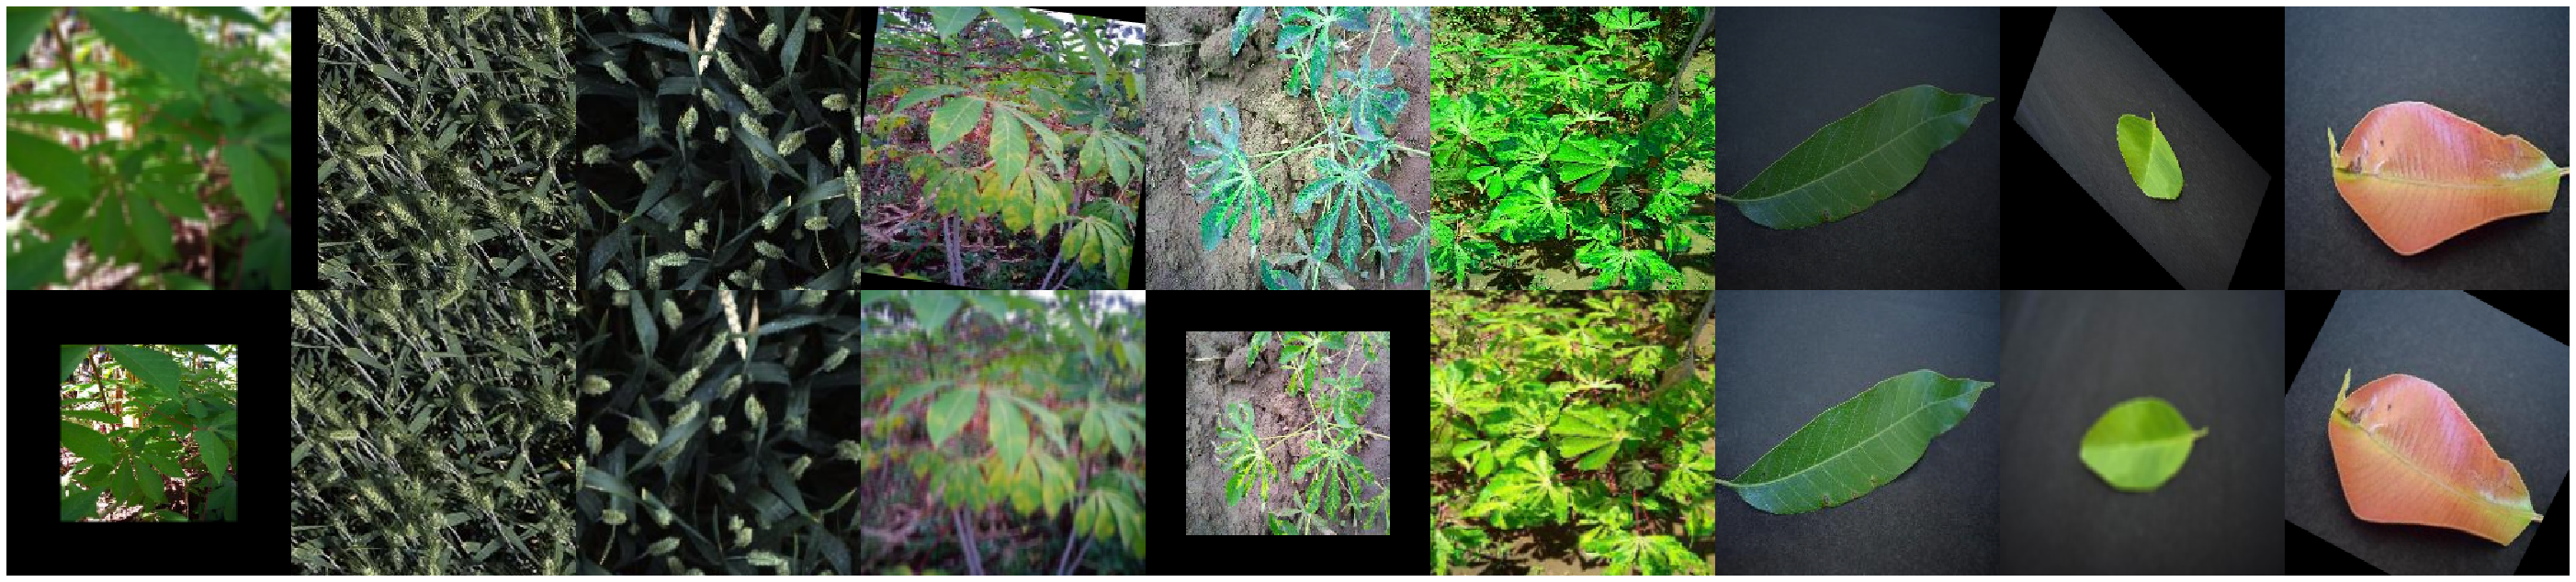

In [51]:
img_mat = np.zeros((2*image_size, 9*image_size,3),dtype='int32')
image = np.array(image)
for i in range(2):
    for j in range(9):
        img_mat[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size,:] = image[i,j,:,:,:]
plt.figure(figsize=(50, 50))
plt.imshow(img_mat)
plt.axis("off")

In [52]:
from tensorflow.keras import applications
base_model = applications.EfficientNetB0(weights='imagenet', input_shape=(image_size, image_size, 3),  include_top=False)

# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(.2)(x)
outputs = keras.layers.Dense(512)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
Total params: 4,968,099
Trainable params: 4,926,076
Non-trainable params: 42,023
_______________________________________

In [53]:
warmup_epoch = 5
total_epoch = 100
lr = 0.001
temperature = 0.1

model = train_util.train(model = model, data = data, batch_size = 32, warmup_epoch = warmup_epoch, total_epoch = total_epoch, lr = lr,  temperature=temperature)

Warmup Epoch 0: time:  1030 loss 0.27785  checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-1
Warmup Epoch 1: time:   954 loss 0.14991  checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-2
Warmup Epoch 2: time:   952 loss 0.12426  checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-3
Warmup Epoch 3: time:   951 loss 0.11106  checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-4
Warmup Epoch 4: time:   952 loss 0.10271  checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-5
Epoch 0: time:   951 loss 0.09678  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-6
Epoch 1: time:   949 loss 0.09076  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-7
Epoch 2: time:   949 loss 0.08555  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-8
Epoch 3: time:   949 loss 0.08233  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-9
Epoch 4: time:   951 loss 0.07985  Checkpoint: models/efficientnetb0_20210312_checkpoints\ck

Epoch 78: time:   947 loss 0.04334  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-84
Epoch 79: time:   947 loss 0.04285  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-85
Epoch 80: time:   947 loss 0.04271  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-86
Epoch 81: time:   948 loss 0.04312  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-87
Epoch 82: time:   949 loss 0.04264  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-88
Epoch 83: time:   947 loss 0.04264  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-89
Epoch 84: time:   947 loss 0.04196  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-90
Epoch 85: time:   947 loss 0.04227  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-91
Epoch 86: time:   946 loss 0.04146  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-92
Epoch 87: time:   946 loss 0.04176  Checkpoint: models/efficientnetb0_20210312_checkpoints\ckpt-93
Epoch 88: 

In [54]:
model.save('model/CL_pretrained_20210312')

INFO:tensorflow:Assets written to: model/CL_pretrained_20210312\assets


In [6]:
#model = keras.models.load_model('model/CL_pretrained_20210224')

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import date

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

import importlib
import data_load
import util


# import image data and combine labels
# import image data and combine labels
def load_data(image_size=224, image_dir='data/multipleplants'):
    X = []
    y = []
    labels = []
    for root, folder, files in os.walk(image_dir):
        #print( folder)
        for f in files:
            #print(f)
            if f.lower().endswith('.jpg') or f.lower().endswith('.png') or f.lower().endswith('.jpeg'):
                #print(root, folder, f)
                img = load_img(f'{root}/{f}', target_size=(image_size,image_size,3))
                img_array = img_to_array(img, dtype='uint8')
                X.append(img_array)
                
                # get y
                specie, classname = root[20:].split('___')
                specie = specie.replace('_', ' ')
                classname = classname.replace('_', ' ')
                if classname[:len(specie)].lower() != specie.lower():
                    classname=specie +' ' + classname
                #print(species.index(specie), classes.index(classname))
                y.append([species.index(specie), classes.index(classname)])
                labels.append([specie, classname])
                
    return np.array(X, dtype=np.uint8), np.array(y), np.array(labels)

In [56]:
x2 = keras.layers.GlobalAveragePooling2D()(model.layers[1].output)
outputs2 = keras.layers.Dense(43)(x2)
model2 = keras.Model(model.layers[1].input, outputs2)

In [57]:
species = ['Apple', 'Bell Pepper', 'Blueberry', 'Cherry (including sour)',
       'Corn (maize)', 'Grape', 'Orange', 'Peach', 'Potato', 'Raspberry',
       'Soybean', 'Squash', 'Strawberry', 'Tomato']

classes = ['Apple Black rot', 'Apple Cedar apple rust', 'Apple healthy' ,'Apple scab',
 'Bell Pepper Bacterial spot' ,'Bell Pepper healthy', 'Blueberry healthy',
 'Cherry (including sour) Powdery mildew',
 'Cherry (including sour) healthy',
 'Corn (maize) Cercospora leaf spot Gray leaf spot',
 'Corn (maize) Common rust ' ,'Corn (maize) Northern Leaf Blight',
 'Corn (maize) healthy' ,'Grape Black rot', 'Grape Esca (Black Measles)',
 'Grape Leaf blight (Isariopsis Leaf Spot)' ,'Grape healthy',
 'Orange Haunglongbing (Citrus greening)' ,'Peach Bacterial spot',
 'Peach healthy', 'Potato Early blight', 'Potato Late blight',
 'Potato healthy', 'Raspberry healthy' ,'Soybean healthy',
 'Squash Powdery mildew' ,'Strawberry Leaf scorch' ,'Strawberry healthy',
 'Tomato American Serpentine Leafminer', 'Tomato Bacterial spot',
 'Tomato Early blight' ,'Tomato Insect Bite' ,'Tomato Late blight',
 'Tomato Leaf Mold', 'Tomato Powdery mildew', 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two-spotted spider mite', 'Tomato Stem rot',
 'Tomato Target Spot' ,'Tomato Wilt', 'Tomato Yellow Leaf Curl Virus',
 'Tomato healthy', 'Tomato mosaic virus']


In [ ]:
batch_size = 64
warm_up_learning_rate = 0.005
warm_up_reduce_lr_patience =3
warm_up_early_stop_patience = 6 
warm_up_min_lr=0.00005
learning_rate = 0.0001
reduce_lr_patience = 5
early_stop_patience = 10
min_lr=0.00001
val_train_epoch=3
#main        
data_x, data_y, labels  = load_data() 
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y[:,1], test_size=0.05, random_state=42)

#importlib.import_module("data_load")

# Warm up head
adam = optimizers.Adam(learning_rate=warm_up_learning_rate)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=warm_up_reduce_lr_patience, 
                           min_lr=warm_up_min_lr)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=warm_up_early_stop_patience, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
for l in model.layers[:-2]:
    l.trainable = False

model2.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model2.fit(data_load.generator_with_label(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

# Train entire network
adam = optimizers.Adam(learning_rate=learning_rate)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=reduce_lr_patience , 
                           min_lr=min_lr)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=early_stop_patience, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

for l in model.layers:
    l.trainable = True

model2.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(data_load.generator_with_label(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

#util.showConfusionMatrix(model, x_val, y_val)
#model2.fit(data_load.generator_with_label(x_val, y_val, batch_size),            
#                    epochs=val_train_epoch,
#                    steps_per_epoch=len(x_train)/batch_size ,
#                    verbose=True
#                   )
    


Epoch 1/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.5716 - sparse_categorical_crossentropy: 2.2600 - val_loss: 0.3637 - val_sparse_categorical_crossentropy: 2.0985
Epoch 2/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.3485 - sparse_categorical_crossentropy: 2.0989 - val_loss: 0.3539 - val_sparse_categorical_crossentropy: 2.0891
Epoch 3/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.3081 - sparse_categorical_crossentropy: 2.0959 - val_loss: 0.3248 - val_sparse_categorical_crossentropy: 2.0515
Epoch 4/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.2802 - sparse_categorical_crossentropy: 2.0911 - val_loss: 0.3158 - val_sparse_categorical_crossentropy: 2.1124
Epoch 5/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.2629 - sparse_categorical_crossentropy: 2.1044 - val_loss: 0.3033 - val_sparse_categorical_crossentropy: 2.1301
Epoch 6/100
1076/1075 [==

Epoch 43/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.0950 - sparse_categorical_crossentropy: 1.9248 - val_loss: 0.2055 - val_sparse_categorical_crossentropy: 1.9444
Epoch 44/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.0949 - sparse_categorical_crossentropy: 1.9275 - val_loss: 0.2049 - val_sparse_categorical_crossentropy: 1.9495
Epoch 45/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.0933 - sparse_categorical_crossentropy: 1.9288 - val_loss: 0.2048 - val_sparse_categorical_crossentropy: 1.9413
Epoch 46/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.0954 - sparse_categorical_crossentropy: 1.9226 - val_loss: 0.2047 - val_sparse_categorical_crossentropy: 1.9439
Epoch 47/100
1076/1075 [==============================] - 252s 234ms/step - loss: 0.0945 - sparse_categorical_crossentropy: 1.9224 - val_loss: 0.2044 - val_sparse_categorical_crossentropy: 1.9465
Epoch 48/100
1076/10

In [44]:
print(len(data_x))

72465


In [46]:
sum(y_val_pred==y_val)/len(y_val)

0.9826158940397351

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_val_pred = np.argmax(model2.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (25,25))
sn.heatmap(df_cm, annot=True)

ValueError: Shape of passed values is (42, 42), indices imply (43, 43)

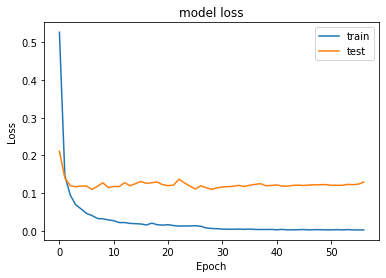

In [12]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

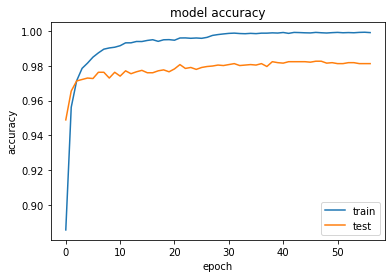

In [43]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [11]:
model2.save('models/EfficientNet_CL_20210314')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/EfficientNet_CL_20210312\assets


In [43]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/EfficientNet_CL_20210223") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/EfficientNet_CL_20210223.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
import cv2
for i in range(5):
    index = np.random.randint(len(x_train))
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y_train[index])

    interpreter = tf.lite.Interpreter(model_path="models/InceptionResNetV2.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (image_size,image_size)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

In [63]:
# Initlize TFLite Invoker
interpreter = tf.lite.Interpreter(model_path="models/EfficientNet_CL_20210223.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']


In [61]:
pred_norm = np.argmax(model2.predict(x_val), axis=1)

print(sum(pred_norm==y_val)/len(pred_norm))

0.9965675057208238


In [67]:
pred_tflite = []
for img in x_val:
    input_data = np.array(np.expand_dims(img, axis = 0), dtype='float32')
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred_tflite.append(np.argmax(output_data))


In [69]:
pred_tflite

[24,
 14,
 41,
 36,
 13,
 24,
 24,
 40,
 41,
 24,
 29,
 41,
 41,
 40,
 38,
 8,
 12,
 10,
 38,
 6,
 28,
 17,
 2,
 35,
 11,
 18,
 2,
 41,
 41,
 5,
 41,
 23,
 41,
 10,
 8,
 10,
 41,
 25,
 24,
 1,
 17,
 20,
 33,
 40,
 24,
 32,
 20,
 36,
 40,
 28,
 41,
 14,
 40,
 24,
 41,
 17,
 17,
 5,
 18,
 24,
 32,
 28,
 17,
 17,
 41,
 7,
 41,
 2,
 41,
 15,
 35,
 28,
 28,
 15,
 41,
 17,
 30,
 25,
 41,
 41,
 35,
 12,
 29,
 29,
 18,
 30,
 13,
 11,
 11,
 41,
 40,
 41,
 17,
 28,
 11,
 40,
 17,
 35,
 36,
 41,
 41,
 7,
 33,
 25,
 41,
 21,
 41,
 33,
 41,
 29,
 41,
 3,
 32,
 41,
 40,
 21,
 25,
 40,
 17,
 10,
 21,
 13,
 17,
 30,
 41,
 32,
 36,
 5,
 8,
 40,
 2,
 2,
 36,
 11,
 28,
 12,
 5,
 36,
 40,
 3,
 21,
 7,
 5,
 24,
 33,
 38,
 35,
 24,
 41,
 41,
 21,
 41,
 41,
 17,
 28,
 28,
 9,
 42,
 7,
 6,
 40,
 25,
 38,
 8,
 6,
 33,
 17,
 41,
 29,
 8,
 24,
 15,
 24,
 24,
 28,
 40,
 40,
 5,
 10,
 18,
 40,
 29,
 24,
 9,
 25,
 17,
 40,
 17,
 17,
 12,
 40,
 9,
 41,
 20,
 40,
 40,
 29,
 3,
 35,
 35,
 23,
 40,
 36,
 25,
 8,
 41,
 

In [68]:
print(sum(pred_tflite==y_val)/len(y_val))

0.9965675057208238
